# ЦЕЛЬ
Исследовать поведение пользователей в обновлённом приложении.

## ЗАДАЧИ
- Определить, насколько обучение сокращает время прохождения этапов игры.
- Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
- Определить, насколько прозрачен процесс взаимодействия с игрой.

### КОНКРЕТНЫЕ ШАГИ (ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ)
- Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
- Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
- Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

# Описание данных 

## Таблица *Event*
    Хранит данные о событиях, которые совершают пользователи. По сути, каждое событие — это факт прохождения пользователем какого-либо этапа игры.

    Название поля	 Описание
    id	            идентификатор события
    user_id	       уникальный идентификатор пользователя, совершившего событие в приложении
    start_time	    дата и время события
    event_type	    тип события 
                (значения: registration — регистрация; 
                tutorial_start — начало обучения; 
                tutorial_finish — завершение обучения; 
                level_choice — выбор уровня сложности; 
                pack_choice — выбор пакетов вопросов)
    tutorial_id	   идентификатор обучения (этот идентификатор есть только у событий обучения)
    selected_level	выбранный уровень сложности обучения

## Таблица *purchase*
    Хранит данные об оплатах, которые совершают пользователи.

    Название поля	 Описание
    id	            идентификатор события
    user_id	       уникальный идентификатор пользователя, совершившего событие в приложении
    event_datetime	дата и время события/покупки
    amount	        сумма оплаты

# Чтение и предобработка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
events = pd.read_csv('Events.csv', sep=',')
purchase = pd.read_csv('purchase.csv', sep=',')

# Создание копий таблиц
events_df = events.copy()
purchase_df = purchase.copy()

Выборка пользователей, зарегистрировавшихся в 2018 году

In [3]:
registered = events_df[(events_df.start_time>='2018-01-01') & (events_df.start_time<'2019-01-01') & (events_df.event_type=='registration')]['user_id'].to_list() 

events_df = events_df[events.user_id.isin(registered)]
purchase_df = purchase_df[purchase_df.user_id.isin(registered)]

In [4]:
# Корректировка наименования столбцов
events_df = events_df.rename(columns={'id': 'event_id'})
purchase_df = purchase_df.rename(columns={'id': 'purchase_id', 'event_datetime': 'start_time'})

# Приведение столбцов времени к формату DataTime
purchase_df['start_time'] = pd.to_datetime(purchase_df['start_time'])
events_df['start_time'] = pd.to_datetime(events_df['start_time'])

# Создание столбца с выделением собития оплаты
purchase_df['event_type'] = 'purchase'

Объединение датафреймов

In [5]:
total_events_df = pd.concat([events_df,purchase_df],sort=False) 

# Сброс индексов в датафрейм + сортировка событий по возрастанию времени
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time') 
total_events_df

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0


# Задача 1

Определить насколько обучение сокращает время прохождения этапов игры.

- Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.

Выделим группы пользавателей не прошедших обучение и группу завершивших обучение

In [6]:
# Группа пользователей завершивших обучение
users_finished_tutorial = set(total_events_df[total_events_df['event_type'] == 'tutorial_finish']['user_id'].unique())
# Группа пользователей не завершивших обучение
users_no_finished_tutorial = set(total_events_df[total_events_df['event_type'] == 'tutorial_start']['user_id'].unique())-users_finished_tutorial
# Группа пользователей не начинавших обучение
users_without_tutor = set(total_events_df['user_id'].unique()) - users_finished_tutorial -users_no_finished_tutorial

Добавим в сводную таблицу столбец с показателем обучения

In [7]:
def group(user):
    if user in users_finished_tutorial:
        return 'finished_tutorial'
    elif user in users_without_tutor:
        return 'without_tutorial'
    else:
        return 'no_finished_tutorial'

# Применим эту функцию, чтобы создать в датафрейме новый признак.
total_events_df['tutorial_group'] = total_events_df['user_id'].apply(group)

total_events_df.head()    

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount,tutorial_group
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN,without_tutorial
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN,finished_tutorial
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN,finished_tutorial
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN,finished_tutorial
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN,finished_tutorial


In [8]:
# проверим, что в добавленном признаке нет пропусков
total_events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68559 entries, 0 to 68558
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_id        66959 non-null  float64       
 1   event_type      68559 non-null  object        
 2   selected_level  8342 non-null   object        
 3   start_time      68559 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         68559 non-null  int64         
 6   purchase_id     1600 non-null   float64       
 7   amount          1600 non-null   float64       
 8   tutorial_group  68559 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 5.2+ MB


Посчитаем для каждой группы скорость прохождения этапов.

Ключевые этапы пути пользователя: регистрация, старт обучения, завершение обучения, выбор уровня сложности вопросов, выбор бесплатных вопросов, покупка платных вопросов.

На практике сценарии пользовательских путей могут быть разными. Поэтому, чтобы не считать временные интервалы между всеми возможными комбинациями событий и получить более наглядные результаты, за точку отсчета всегда будем брать событие registration.

In [9]:
# Создадим сводную таблицу с данными, когда пользователи впервые переходили на каждый этап.
users_events_datetime = total_events_df.pivot_table(
    values='start_time',
    index=['user_id'],
    columns='event_type',
    aggfunc='min'
)
users_events_datetime

event_type,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
user_id,,,,,,
27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT
27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40
27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11
27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51
27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40
...,...,...,...,...,...,...
47753,2018-12-31 22:36:19,2018-12-31 22:38:05,NaT,2018-12-31 18:58:55,2018-12-31 20:57:07,2018-12-31 20:54:56
47754,NaT,NaT,NaT,2018-12-31 19:14:08,NaT,NaT
47755,2019-01-01 05:04:52,NaT,NaT,2018-12-31 21:15:14,2019-01-01 00:09:30,2019-01-01 00:08:14


In [10]:
# Рассчитаем длительность переходов на каждый этап и запишем их в новую таблицу.
users_events_time = users_events_datetime.copy()
events = ['tutorial_start', 'tutorial_finish', 'level_choice', 'pack_choice', 'purchase']
for event in events:
    users_events_time['td_{}'.format(event)] = users_events_time[event] - users_events_time['registration']

# Уберем лишние столбцы.
users_events_time = users_events_time.drop(
    ['registration', 'tutorial_start', 'tutorial_finish', 'level_choice', 'pack_choice', 'purchase'], axis=1)

users_events_time['user_id'] = users_events_time.index    
users_events_time['tutorial_group'] = users_events_time['user_id'].apply(group)

users_events_time

event_type,td_tutorial_start,td_tutorial_finish,td_level_choice,td_pack_choice,td_purchase,user_id,tutorial_group
user_id,,,,,,,
27832,NaT,NaT,NaT,NaT,NaT,27832,without_tutorial
27833,0 days 13:40:15,0 days 13:42:43,NaT,NaT,NaT,27833,finished_tutorial
27834,0 days 11:11:01,0 days 11:12:51,NaT,NaT,NaT,27834,finished_tutorial
27835,0 days 03:06:04,0 days 03:11:28,0 days 08:42:35,0 days 08:43:56,NaT,27835,finished_tutorial
27836,0 days 01:26:33,0 days 02:14:51,NaT,NaT,NaT,27836,finished_tutorial
...,...,...,...,...,...,...,...
47753,0 days 01:56:01,0 days 01:58:12,0 days 03:37:24,0 days 03:39:10,NaT,47753,finished_tutorial
47754,NaT,NaT,NaT,NaT,NaT,47754,without_tutorial
47755,0 days 02:53:00,0 days 02:54:16,0 days 07:49:38,NaT,NaT,47755,finished_tutorial


Рассчитаем средние показателя длительности перехода для каждой из группы:

In [11]:
users_events_datetime_mn = users_events_time.groupby('tutorial_group')[
    ['td_tutorial_start', 'td_tutorial_finish', 'td_level_choice', 'td_pack_choice', 'td_purchase']
].mean()
users_events_datetime_mn

event_type,td_tutorial_start,td_tutorial_finish,td_level_choice,td_pack_choice,td_purchase
tutorial_group,,,,,
finished_tutorial,0 days 04:31:04.938146341,0 days 04:43:18.761268292,0 days 07:05:36.854819357,0 days 07:10:35.660162287,4 days 00:30:03.247408431
no_finished_tutorial,0 days 05:25:02.892412935,NaT,0 days 08:12:57.551816958,0 days 08:22:32.392197125,4 days 05:32:53.213740458
without_tutorial,NaT,NaT,0 days 05:15:33.122448979,0 days 05:07:16.175675675,4 days 09:06:01.909090909


Визуализируем полученные данные. Для этого переведём полученное время в числовой формат и заполним пропуски нулями.

In [12]:
users_events_datetime_mean = round(users_events_datetime_mn/pd.Timedelta('1 hour'), 2).drop('no_finished_tutorial').fillna(0).reset_index()

users_events_datetime_mean = users_events_datetime_mean.fillna(0)
users_events_datetime_mean

event_type,tutorial_group,td_tutorial_start,td_tutorial_finish,td_level_choice,td_pack_choice,td_purchase
0,finished_tutorial,4.52,4.72,7.09,7.18,96.5
1,without_tutorial,0.00,0.00,5.26,5.12,105.1


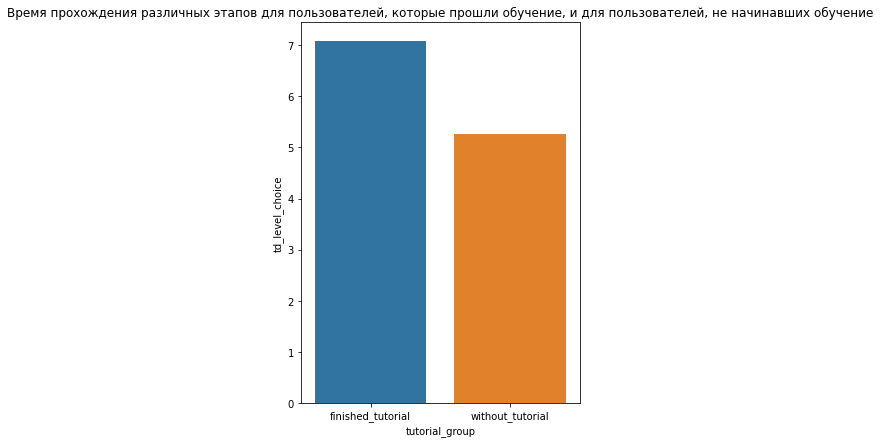

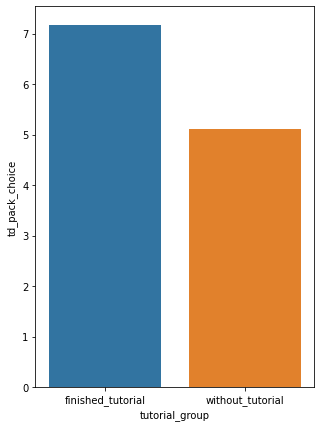

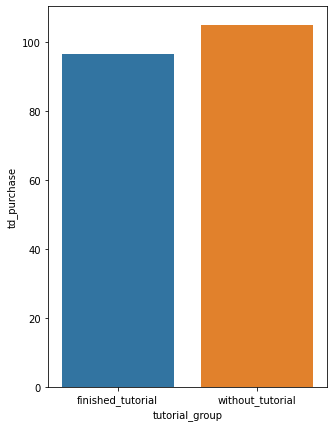

In [13]:
fig = plt.figure(figsize=(5, 7))

barplot = sns.barplot(
    data=users_events_datetime_mean,
    x='tutorial_group',
    y='td_level_choice'
)
barplot.set_title('Bремя прохождения различных этапов для пользователей, которые прошли обучение, и для пользователей, не начинавших обучение')

fig = plt.figure(figsize=(5, 7))

barplot = sns.barplot(
    data=users_events_datetime_mean,
    x='tutorial_group',
    y='td_pack_choice'
)
fig = plt.figure(figsize=(5, 7))

barplot = sns.barplot(
    data=users_events_datetime_mean,
    x='tutorial_group',
    y='td_purchase'
)

Как можно увидеть, выбор уровня и пакетов вопросов в группе пользователей не прошедших обучение происходит примерно на два часа быстрее, чем в группе пользователей прошедших обучение. При этом первую покупку пользователи не прошедщие обучение совершают на 9 часов позже.

# Задача 2

Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.

- Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь

Выделим группу пользователей совершивших оплату

In [14]:
users_purchase = set(total_events_df[total_events_df['event_type'] == 'purchase']['user_id'].unique())

Добавим соответстующий признак в главную таблицу

In [15]:
def pay_group(user):
    if user in users_purchase:
        return 'paid'
    else:
        return 'no_paid'

# Применим эту функцию, чтобы создать в датафрейме новый признак.
total_events_df['pay_group'] = total_events_df['user_id'].apply(pay_group)

total_events_df.head()    

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount,tutorial_group,pay_group
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN,without_tutorial,no_paid
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN,finished_tutorial,no_paid
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN,finished_tutorial,no_paid
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN,finished_tutorial,no_paid
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN,finished_tutorial,no_paid


In [16]:
# проверим, что в добавленном признаке нет пропусков
total_events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68559 entries, 0 to 68558
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_id        66959 non-null  float64       
 1   event_type      68559 non-null  object        
 2   selected_level  8342 non-null   object        
 3   start_time      68559 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         68559 non-null  int64         
 6   purchase_id     1600 non-null   float64       
 7   amount          1600 non-null   float64       
 8   tutorial_group  68559 non-null  object        
 9   pay_group       68559 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(4)
memory usage: 5.8+ MB


Создадим таблицу с показателем количества раз пройденного обучения и факта свершения оплаты

In [17]:
tutorial_group_df = total_events_df.groupby(['user_id', 'tutorial_group'])['tutorial_id'].nunique().reset_index()
tutorial_group_df = tutorial_group_df.rename(columns={'tutorial_id': 'tutorial_amount'})

tutorial_group_df['pay_group'] = tutorial_group_df.apply(lambda x: 1 if x['user_id'] in users_purchase else 0, axis=1)
tutorial_group_df

,user_id,tutorial_group,tutorial_amount,pay_group
0,27832,without_tutorial,0,0
1,27833,finished_tutorial,1,0
2,27834,finished_tutorial,1,0
3,27835,finished_tutorial,1,0
4,27836,finished_tutorial,2,0
...,...,...,...,...
19921,47753,finished_tutorial,1,0
19922,47754,without_tutorial,0,0
19923,47755,finished_tutorial,1,0
19924,47756,finished_tutorial,1,0


Посмотрим распределение количеств оплат и количеств обучений для группы пользователей с различными этапами прохождения обучения

In [18]:
tutorial_pay_count_all = tutorial_group_df.groupby(['tutorial_group', 'tutorial_amount']).agg({'pay_group': 'sum'}).reset_index()
tutorial_pay_count_all

,tutorial_group,tutorial_amount,pay_group
0,finished_tutorial,1,1083
1,finished_tutorial,2,211
2,finished_tutorial,3,51
3,finished_tutorial,4,30
4,finished_tutorial,5,16
5,finished_tutorial,6,14
6,finished_tutorial,7,12
7,finished_tutorial,8,13
8,finished_tutorial,9,17
9,no_finished_tutorial,1,124


Как можно заметить практически все покупки совершают пользователи завершившие обучение. Пользователи, не прошедшие обучение, совершили всего 22 покупки.

Проверим существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь

In [19]:
tutorial_pay_count = tutorial_pay_count_all[tutorial_pay_count_all['tutorial_group'] != 'without_tutorial'].drop(['tutorial_group'], axis=1)
tutorial_pay_count = tutorial_pay_count.groupby(['tutorial_amount'])['pay_group'].sum().reset_index()
tutorial_pay_count

,tutorial_amount,pay_group
0,1,1207
1,2,218
2,3,51
3,4,30
4,5,16
5,6,14
6,7,12
7,8,13
8,9,17


Рассмотрим полученные данные на диаграмме

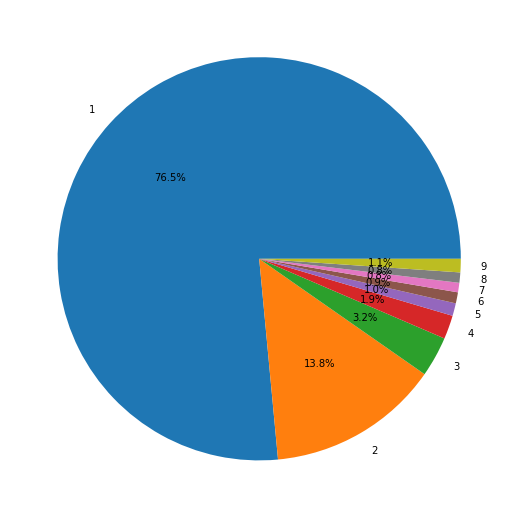

In [20]:
fig = plt.figure(figsize=(7, 7))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    tutorial_pay_count['pay_group'],
    labels=tutorial_pay_count.tutorial_amount,
    autopct='%.1f%%'
);

Большенство покупок совершается пользователями прошедшими обучение только один раз - это 76,5% от всех покупок, далее весьма заметно снижение количества покупок, чем больше попыток пройти обучение, тем меньше совершено покупок.

# Задача 3

Определить, насколько прозрачен процесс взаимодействия с игрой.

- Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

In [21]:
# Создаем датафреймы с событиями начало обучения и выбором уровня сложности:
started_tutorial_df = total_events_df[total_events_df["event_type"] == "tutorial_start"].rename(columns={"start_time": "tutorial_start_time"}).drop(
    ['purchase_id', 'amount', 'tutorial_group', 'pay_group', 'selected_level'], axis=1)
level_choice_df = total_events_df[total_events_df["event_type"] == "level_choice"].rename(columns={"start_time": "level_choice_time"}).drop(
    ['purchase_id', 'amount', 'tutorial_group', 'pay_group', 'selected_level'], axis=1)

# Объединяем датафреймы с началом обучения и выбором уровня сложности по user_id:
started_tutorial_level_choice_df = started_tutorial_df.merge(level_choice_df, on="user_id", how="inner")
started_tutorial_level_choice_df

,event_id_x,event_type_x,tutorial_start_time,tutorial_id_x,user_id,event_id_y,event_type_y,level_choice_time,tutorial_id_y
0,80316.0,tutorial_start,2018-01-01 15:00:51,31506.0,27835,80327.0,level_choice,2018-01-01 20:37:22,NaN
1,80323.0,tutorial_start,2018-01-01 19:11:36,31509.0,27839,80331.0,level_choice,2018-01-01 22:37:50,NaN
2,80337.0,tutorial_start,2018-01-02 02:07:07,31511.0,27840,80344.0,level_choice,2018-01-02 05:18:42,NaN
3,80338.0,tutorial_start,2018-01-02 03:03:44,31512.0,27845,80346.0,level_choice,2018-01-02 06:19:18,NaN
4,80349.0,tutorial_start,2018-01-02 07:08:00,31514.0,27845,80346.0,level_choice,2018-01-02 06:19:18,NaN
...,...,...,...,...,...,...,...,...,...
12681,147236.0,tutorial_start,2018-12-31 07:14:38,49549.0,47732,147240.0,level_choice,2018-12-31 09:59:00,NaN
12682,147242.0,tutorial_start,2018-12-31 10:21:11,49550.0,47747,147245.0,level_choice,2018-12-31 12:24:40,NaN
12683,147253.0,tutorial_start,2018-12-31 20:54:56,49552.0,47753,147256.0,level_choice,2018-12-31 22:36:19,NaN
12684,147260.0,tutorial_start,2019-01-01 00:08:14,49553.0,47755,147265.0,level_choice,2019-01-01 05:04:52,NaN


In [22]:
# Подсчитываем время между событиями начало обучения и выбором уровня сложности:
started_tutorial_level_choice_df["timedelta"] = (started_tutorial_level_choice_df["tutorial_start_time"]- started_tutorial_level_choice_df["level_choice_time"])/pd.Timedelta('1 hour')
started_tutorial_level_choice_df1 = started_tutorial_level_choice_df[started_tutorial_level_choice_df["timedelta"] > 0]

In [23]:
print('Количество пользователей выбравших обучение после выбора уровня сложности:', started_tutorial_level_choice_df1['user_id'].nunique())
print('Что составляет:', round(started_tutorial_level_choice_df1['user_id'].nunique()/started_tutorial_level_choice_df['user_id'].nunique()*100,2), '% от общего количества пользователей')

Количество пользователей выбравших обучение после выбора уровня сложности: 1386
Что составляет: 16.81 % от общего количества пользователей


Из чего можно сделать вывод, что процесс взаимодействия с игрой не до конца интуинтивно понятен.

# Выводы

Гипотеза 1.

Результаты расчетов поведения пользователей показали, что время прохождения различных этапов у пользователей, которые прошли обучение, и пользователей, не начинавших обучение, отличаются. Так была выяснена закономерность, что пользователи, которые прошли обучение, проходят все этапы игры быстрее, чем пользователи, не начинавшие обучение.  
Например, время прохождения от этапа регистрации до оплаты для пользователей, которые прошли обучение, составляет 96.5 часов, а для пользователей, не начинавших обучение 105.1 часов.


Гипотеза 2.

Расчеты показывают, что успешное обучение влияет на оплату. Наибольший процент пользователей, свершивших покупку, приходится на пользователей, прошедших обучение один раз и составляет 76,5%. ПОльзователи ни разу не прошедшие обучение свершили только 22 покупки.

Гипотеза 3.

16,81% пользователей начинают обучение после выбора уровня сложности тренировок. Это позволяет оценить прозрачность процесса взаимодействия с игрой и показывает, что работа с приложением непонятна достаточно большому количеству пользователей, так как они после выбора уровня сложности тренировок обращаются к обучению.